In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Load the annotations.

In [3]:
import json
import pandas as pd

sats = []

with open('data/spotGEO/train_anno.json') as f:
    for ann in json.load(f):
        for i, coords in enumerate(ann['object_coords']):
            sats.append({
                'sequence': ann['sequence_id'],
                'frame': ann['frame'],
                'satellite': i + 1,
                'x': coords[0],
                'y': coords[1],
            })
    
sats = pd.DataFrame(sats)
sats = sats.set_index(['sequence', 'frame', 'satellite'])
sats.head()

x           y
sequence frame satellite                        
1        1     1          502.406250  237.114583
               2          490.381836  221.811523
               3          140.874332  129.093583
         2     1          530.406250  214.114583
               2          518.381836  198.811523

Load the images.

In [6]:
import pathlib
import imageio

train = {
    (int(seq.name), int(frame.stem)): imageio.imread(frame).T
    for seq in pathlib.Path('data/spotGEO/train').glob('*')
    for frame in seq.glob('*.png')
}

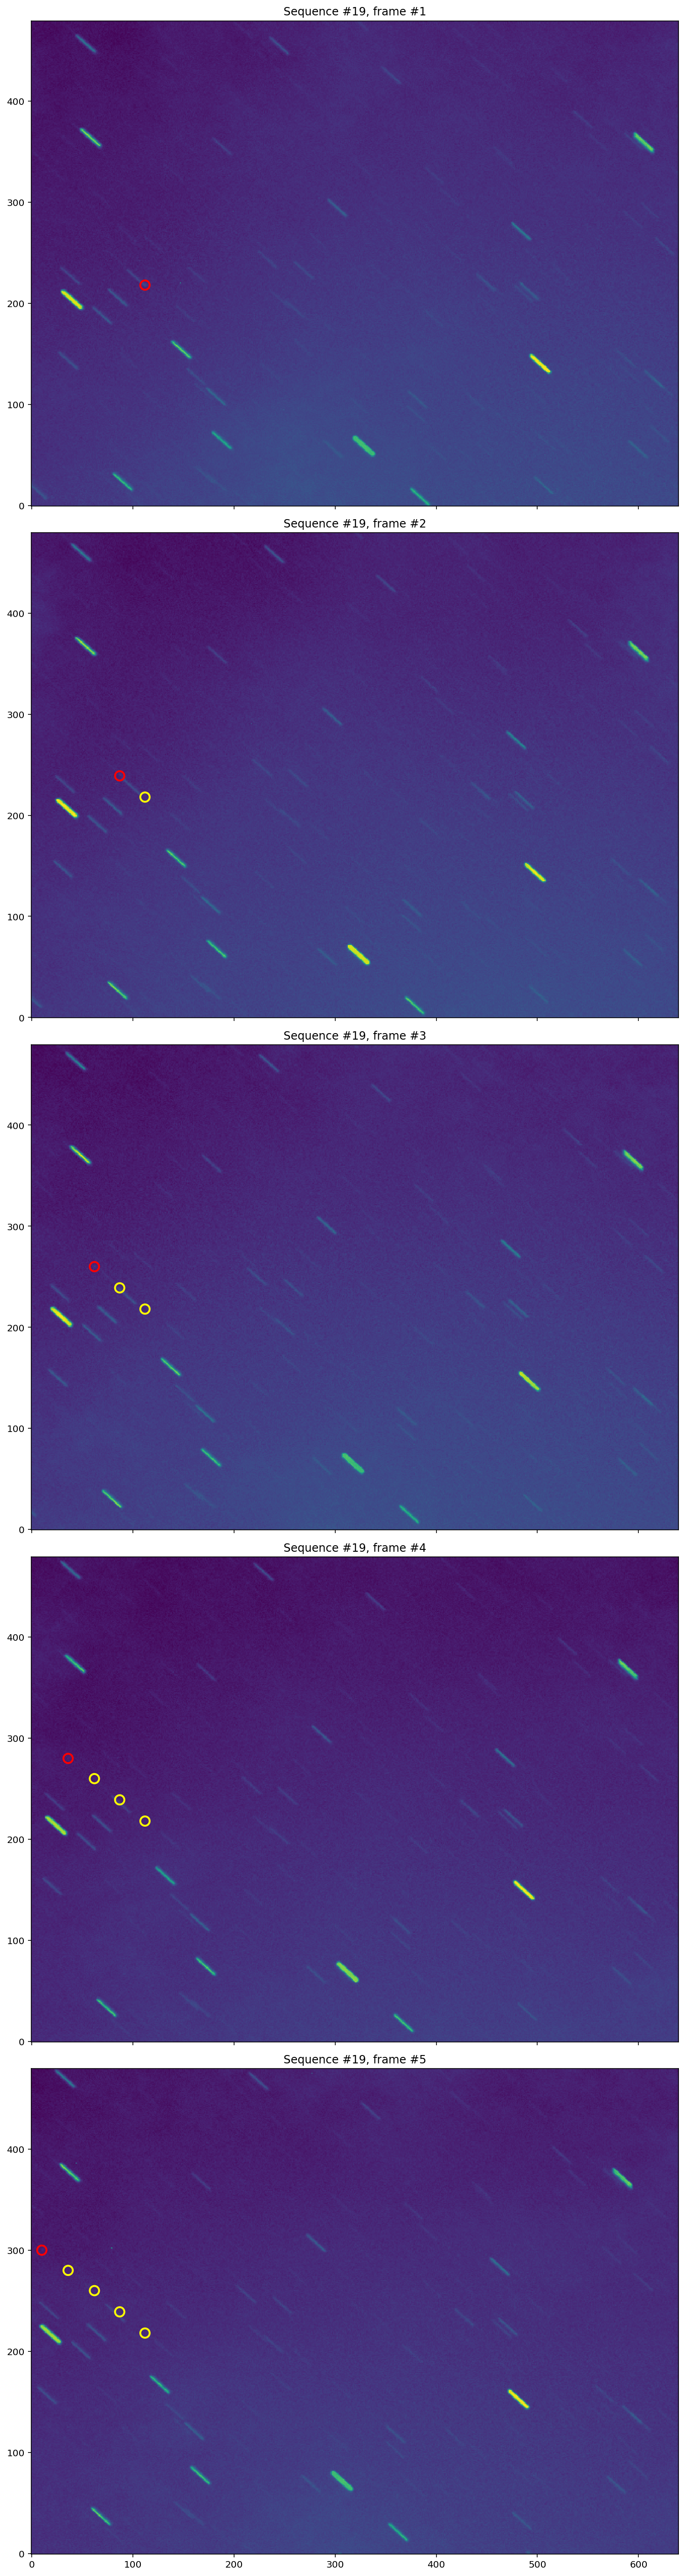

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import ImageGrid

def viz_sequence(seq, df):
    
    # Make one image for each frame
    fig = plt.figure(figsize=(15, 10 * 5)) # 5 frames in each sequence
    grid = ImageGrid(
        fig, 111,  
        nrows_ncols=(5, 1),
        axes_pad=.4,
    )

    frames = df.loc[seq]
    trajectories = []

    for frame, sats in frames.groupby('frame'):
    
        # Sky
        ax = grid[frame - 1]
        ax.imshow(train[seq, frame].T, origin='lower')
        ax.set_title(f'Sequence #{seq}, frame #{frame}')

        # Current positions
        for _, sat in sats.iterrows():
            ax.scatter(sat['x'].astype(int), sat['y'].astype(int), s=100, facecolors='none', edgecolors='red', linewidths=2)
            
        # Old positions
        for old_sats in trajectories:
            for _, sat in old_sats.iterrows():
                ax.scatter(sat['x'].astype(int), sat['y'].astype(int), s=100, facecolors='none', edgecolors='yellow', linewidths=2)
        trajectories.append(sats)
        
        ax.set_xlim(-.5, 639.5)
        ax.set_ylim(-.5, 479.5)
    
    return fig

fig = viz_sequence(19, df=sats)

Now let's load the interesting pixels, those that have the potential of being satellites.

In [48]:
interesting = pd.read_pickle('data/interesting.pkl').set_index(['part', 'sequence', 'frame'])

# Collapse each region into its centroid
interesting = interesting.groupby(['part', 'sequence', 'frame', 'region'])[['x', 'y']].mean().astype(int)

## Feature extraction

In [49]:
import numpy as np

def region(img: np.ndarray, x: int, y: int, w: int):
    """Returns the square of length width with (x, y) being at the center."""
    return img[
        max(x - w, 0) : min(x + w + 1, img.shape[0]),
        max(y - w, 0) : min(y + w + 1, img.shape[1])
    ]

def extract_features(img, x, y):
    r3x3 = region(img, x, y, 3)
    r5x5 = region(img, x, y, 3)
    return {
        'pixel_value': img[x, y],
        '3x3_std': r3x3.std(),
        '3x3_min': r3x3.min(),
        '3x3_max': r3x3.max(),
        '3x3_ptp': np.ptp(r3x3),
        '5x5_std': r5x5.std(),
        '5x5_min': r5x5.min(),
        '5x5_max': r5x5.max(),
        '5x5_ptp': np.ptp(r5x5)
    }

Negative samples.

In [50]:
import tqdm

samples = {}

for (sequence, frame, _), coord in tqdm.tqdm(interesting.loc['train'].sample(100000).iterrows(), position=0):
    
    img = train[sequence, frame]  # can be loaded from the dist
    
    x, y = coord['x'], coord['y']
    
    samples['train', sequence, frame, x, y] = {
        'is_satellite': False,
        **extract_features(img, x, y)
    }

Positive samples.

In [51]:
for (sequence, frame, _), coord in tqdm.tqdm(sats.iterrows(), position=0):
    
    img = train[sequence, frame]  # can be loaded from the dist
    
    x, y = int(coord['x']), int(coord['y'])
    
    samples['train', sequence, frame, x, y] = {
        'is_satellite': True,
        **extract_features(img, x, y)
    }

Test samples. Instead of trying to classify each pixel, we only look at the interesting ones, i.e. that have some potential of being a satellite.

In [52]:
for seq_path in tqdm.tqdm(list(pathlib.Path('data/spotGEO/test').glob('*')), position=0):
    sequence = int(seq_path.name)
    
    for frame_path in seq_path.glob('*.png'):
        frame = int(frame_path.stem)
        
        img = imageio.imread(frame_path).T
        coords = interesting.loc['test', sequence, frame].iterrows()
        
        for _, coord in coords:
            x = coord['x']
            y = coord['y']
            samples['test', sequence, frame, x, y] = {
                'is_satellite': None,
                **extract_features(img, x, y)
            }

100%|██████████| 5120/5120 [13:34<00:00,  6.29it/s]


Now we merge the training pixels and test pixels into a single dataframe.

In [53]:
samples = pd.DataFrame.from_dict(samples, orient='index')
samples.index.names = ['part', 'sequence', 'frame', 'x', 'y']
samples.head()

is_satellite  pixel_value   3x3_std  3x3_min  \
part  sequence frame x   y                                                  
train 876      1     80  477        False           64  1.292092       62   
      297      4     379 268        False           64  4.699110       46   
      1128     4     38  361        False           88  3.742214       76   
      782      3     399 261        False           53  2.114388       45   
      540      3     522 346        False          199  3.348929      190   

                              3x3_max  3x3_ptp   5x5_std  5x5_min  5x5_max  \
part  sequence frame x   y                                                   
train 876      1     80  477       67        5  1.292092       62       67   
      297      4     379 268       66       20  4.699110       46       66   
      1128     4     38  361       89       13  3.742214       76       89   
      782      3     399 261       54        9  2.114388       45       54   
      540      3     522 346      204       14  3.348929      190      204   

                              5x5_ptp  
part  sequence frame x   y             
train 876      1     80  477        5  
      297      4     379 268       20  
      1128     4     38  361       13  
      782      3     399 261        9  
      540      3     522 346       14

## Learning phase

In [54]:
from sklearn import utils

X_train = samples.loc['train'].copy()
y_train = X_train.pop('is_satellite').astype(bool)
X_train, y_train = utils.shuffle(X_train, y_train, random_state=42)

X_test = samples.loc['test'].drop(columns='is_satellite')

In [55]:
import lightgbm
from sklearn import metrics
from sklearn import model_selection
from sklearn import utils

model = lightgbm.LGBMClassifier(
    random_state=42
)

cv = model_selection.GroupKFold(n_splits=5)
groups = X_train.index.get_level_values('sequence')
oof = pd.Series(dtype=bool, index=X_train.index)
y_test = pd.DataFrame(index=X_test.index)

for i, (fit_idx, val_idx) in enumerate(cv.split(X_train, y_train, groups=groups)):
    
    X_fit = X_train.iloc[fit_idx]
    y_fit = y_train.iloc[fit_idx]
    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    model.fit(
        X_fit, y_fit,
        eval_set=[(X_fit, y_fit), (X_val, y_val)],
        eval_names=['fit', 'val'],
        verbose=30
    )
    oof.iloc[val_idx] = model.predict(X_val)
    
    y_test[i] = model.predict_proba(X_test)[:, 1]
    
    print()

print(metrics.classification_report(y_train, oof, digits=4))

[30]	fit's binary_logloss: 0.182153	val's binary_logloss: 0.182606
[60]	fit's binary_logloss: 0.173888	val's binary_logloss: 0.177976
[90]	fit's binary_logloss: 0.169362	val's binary_logloss: 0.176771

[30]	fit's binary_logloss: 0.181967	val's binary_logloss: 0.183459
[60]	fit's binary_logloss: 0.17363	val's binary_logloss: 0.179138
[90]	fit's binary_logloss: 0.169069	val's binary_logloss: 0.178109

[30]	fit's binary_logloss: 0.178692	val's binary_logloss: 0.195436
[60]	fit's binary_logloss: 0.170223	val's binary_logloss: 0.191783
[90]	fit's binary_logloss: 0.165656	val's binary_logloss: 0.190916

[30]	fit's binary_logloss: 0.181615	val's binary_logloss: 0.184529
[60]	fit's binary_logloss: 0.173226	val's binary_logloss: 0.18066
[90]	fit's binary_logloss: 0.168432	val's binary_logloss: 0.180004

[30]	fit's binary_logloss: 0.181213	val's binary_logloss: 0.186926
[60]	fit's binary_logloss: 0.172881	val's binary_logloss: 0.182441
[90]	fit's binary_logloss: 0.168583	val's binary_logloss: 0.

## Make the submission

Build it according to the specified format.

In [56]:
sub = []

for (sequence, frame), g in y_test[0].groupby(['sequence', 'frame']):
    
    coords = []
    
    for (_, __, x, y), pred in g.iteritems():
        if pred:
            coords.append([int(x), int(y), pred])
            
    coords = sorted(coords, key=lambda x: x[2], reverse=True)
    coords = [[x, y] for x, y, _ in coords[:30]]
            
    sub.append({
        'sequence_id': int(sequence),
        'frame': int(frame),
        'num_objects': len(coords),
        'object_coords': coords
    })

Save it and zip it.

In [57]:
import json
import os
import zipfile

with open('submission.json', 'w') as f:
    json.dump(sub, f)
    
with zipfile.ZipFile('submission.zip', mode='w') as f:
    f.write('submission.json')
    
os.remove('submission.json')